# ***Fake News Analysis***

### MATH475 Final Project

Authors:
- Preston Knepper
- Zachary Eanes
- Kevin McCall

__Link to Dataset:__ https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

This was completed with minimal AI assistance.

## ***Part I: Data Exploration and Preprocessing***
Due: 11/24/2024


## **Exploratory Data Analysis**

In this section of the assignment, we begin by exploring our fake news dataset. This includes many parts, such as removing unnecessary columns, checking for missing values, visualizing the data, and attempting to find general trends and correlations in our data.

First, we begin by looking at the basic information our dataset contains. 

In [22]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

# save the dataset into a variable
df = pd.read_csv("WELFake_Dataset.csv")

In [23]:
# display initial information about the dataset
print("==== HEAD ====\n", df.head(10), "\n")
print("==== SAMPLE ====\n", df.sample(10), "\n")
print(df.info())

==== HEAD ====
    Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   
5           5  About Time! Christian Group Sues Amazon and SP...   
6           6  DR BEN CARSON TARGETED BY THE IRS: “I never ha...   
7           7  HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...   
8           8  Sports Bar Owner Bans NFL Games…Will Show Only...   
9           9  Latest Pipeline Leak Underscores Dangers Of Da...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last 


### ***Handling missing data***

Since we've observed less than 100 missing titles and less than 100 missing texts, we will remove them from the dataset. We do this because the missing data is a small percentage of the total data and we can still perform analysis on the remaining data. Along with this, handling the missing data would've been tedious.

In [24]:
# remove missing values since we have so few
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  71537 non-null  int64 
 1   title       71537 non-null  object
 2   text        71537 non-null  object
 3   label       71537 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.7+ MB
None


In [25]:
# change the 0 to false and 1 to true
df['label'] = df['label'].replace({0: 'false', 1: 'true'})

# change the label to category, 0 or 1
df['label'] = df['label'].astype('category')

### ***Column Analysis***
Our dataset had 4 columns with 71,537 entries (after removal). The columns are id, title, text, and label. We interpret and use the columns as follows:

- **ID:** will not be used.
- **Title:** is the title of the news article.
- **Text:** the body text of the news article.
- **Label:** is 1 if the article is true and 0 if the article is false.

We will be looking into the distribution of title and text lengths as well as the distributions of real vs fake articles.

In [26]:
# count our label values
df["label"].value_counts()

label
true     36509
false    35028
Name: count, dtype: int64

Handily, we have roughly equal counts of fake new and real new articles.

In [27]:
# make a new column which is the length of title and text 
with_len = df.copy()
with_len["title_len"] = with_len["title"].apply(len)
with_len["text_len"] = with_len["text"].apply(len)
with_len.head()

def count_uppercase(text):
    """ 
    Counts the number of uppercase characters in a text.

    Args:
        text (str): The text to count uppercase characters in.
    """
    count = 0
    for char in text:
        if char.isalpha() and char.upper() == char:
            count += 1
    return count

# apply the function to the title and text columns
with_len["uppercase_title_len"] = with_len["title"].apply(count_uppercase)
with_len["uppercase_text_len"] = with_len["text"].apply(count_uppercase)

## ***Visualizations***

Next we will be visualizing the distribution of all of our columns, as well as comparing them to label. This is aims to see if there's a relation between the columns shares some form of relation with the label.

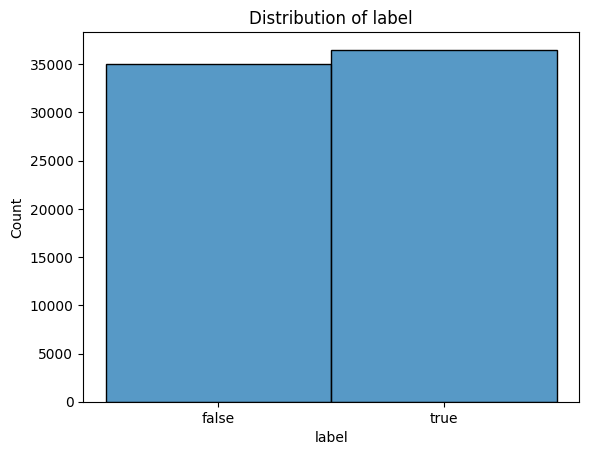

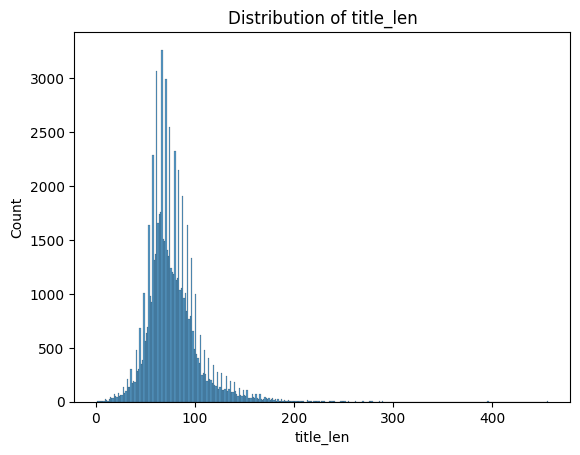

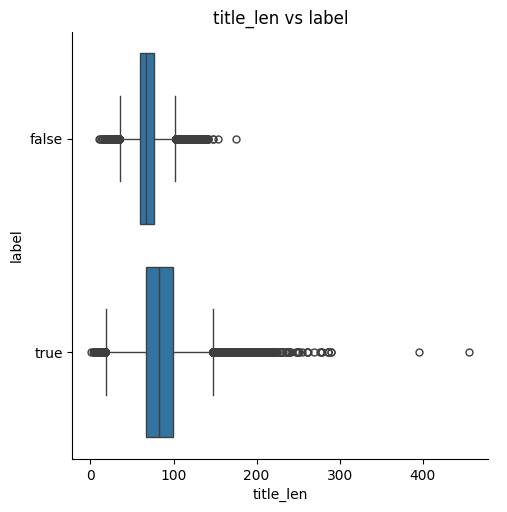

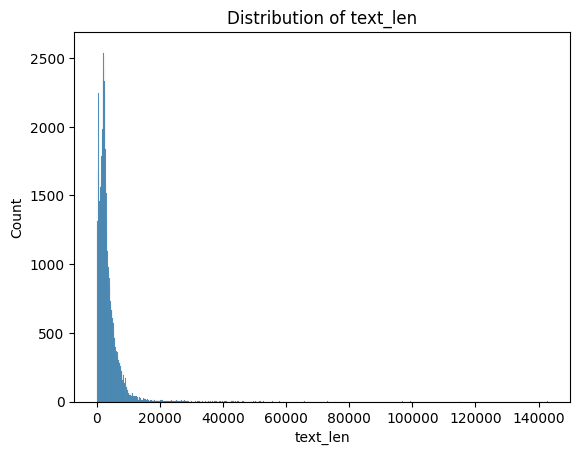

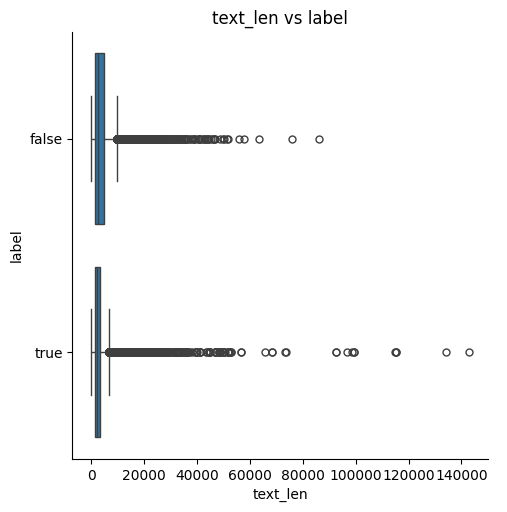

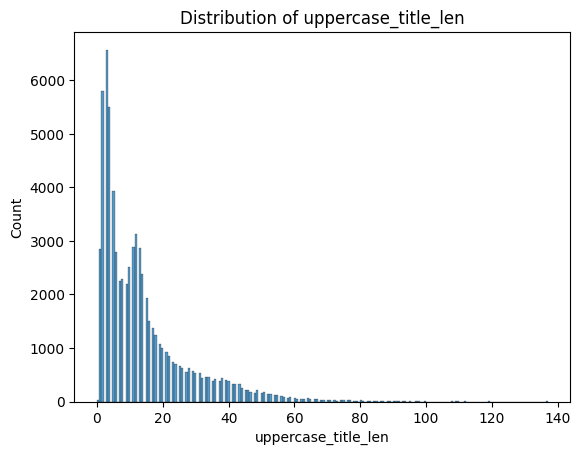

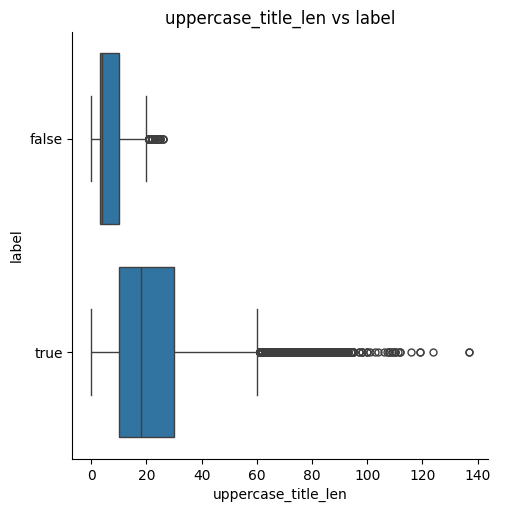

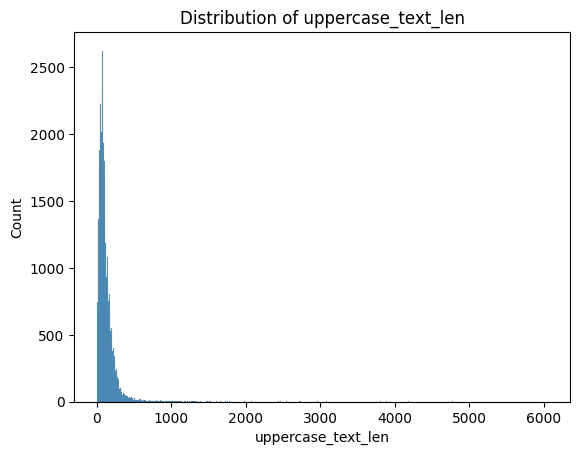

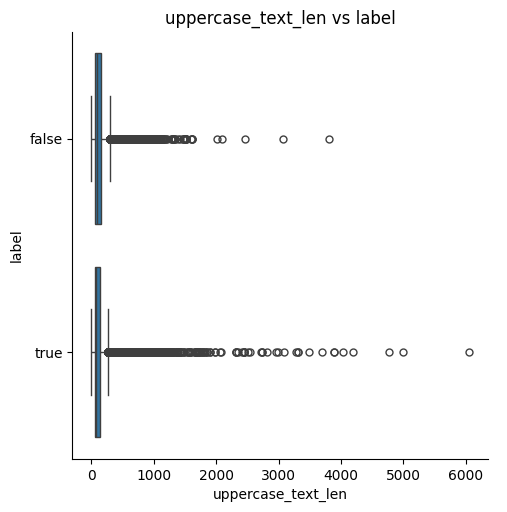

In [28]:
def make_plots():
    """ 
    Plot various columns in our dataset.
    """
    # make plots of the distribution of the new columns, and how they compare to our label
    for name in ["label", "title_len", "text_len", "uppercase_title_len", "uppercase_text_len"]:
        # make histogram to see distribution of column
        sn.histplot(with_len[name])
        plt.title(f"Distribution of {name}")
        plt.show()

        # only make a plot vs. label IF it's not the label column itself
        if name != "label":
            # make a boxplot to see how the column compares to the label
            sn.catplot(data=with_len, x=name, y="label", kind="box")
            plt.title(f"{name} vs label")
            plt.show()

make_plots()

Next we look into outliers in our dataset.

In [29]:
# get the indices of rows where the text length is greater than 60,000
too_long = with_len[with_len["text_len"] > 60000].index

# drop the rows with those indices
df.drop(too_long, inplace=True)
with_len.drop(too_long, inplace=True)

Since we cannot visually tell a correlation between length and fakeness and since there are 19 major outliers with > 60000 text_len, we will drop these articles.  

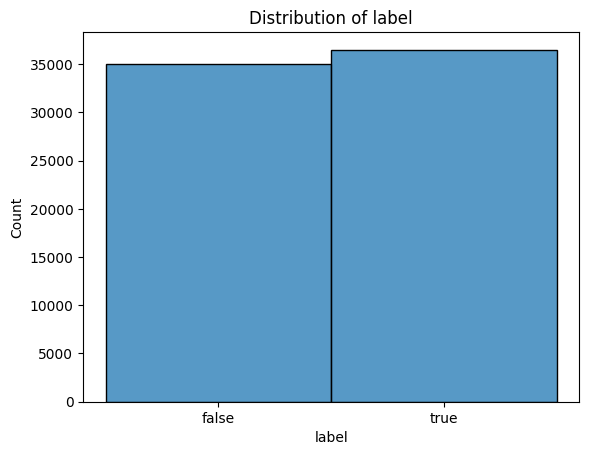

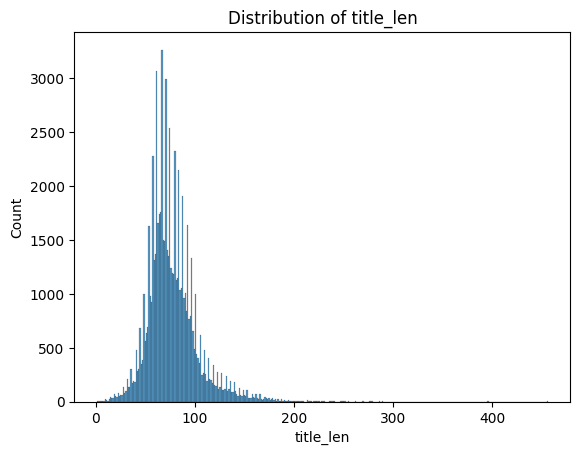

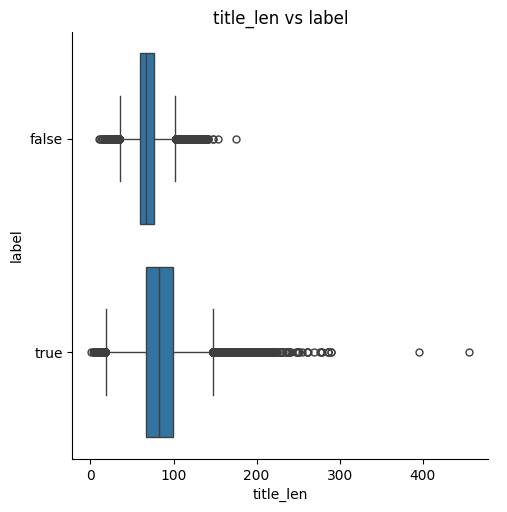

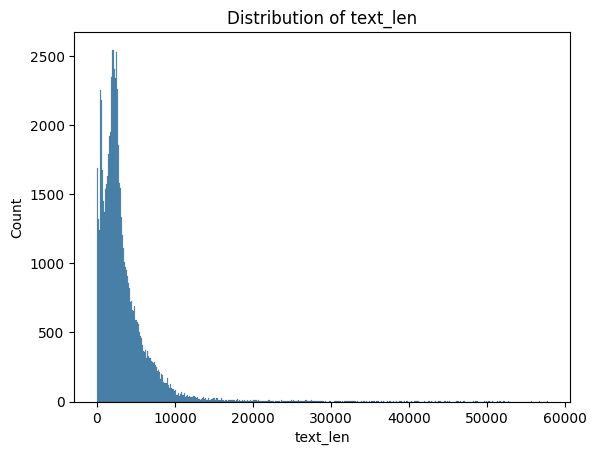

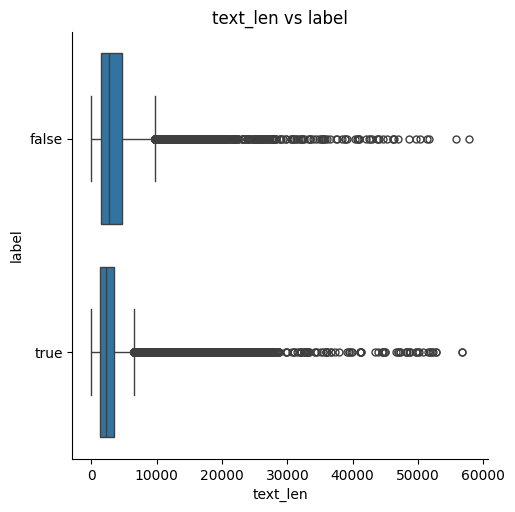

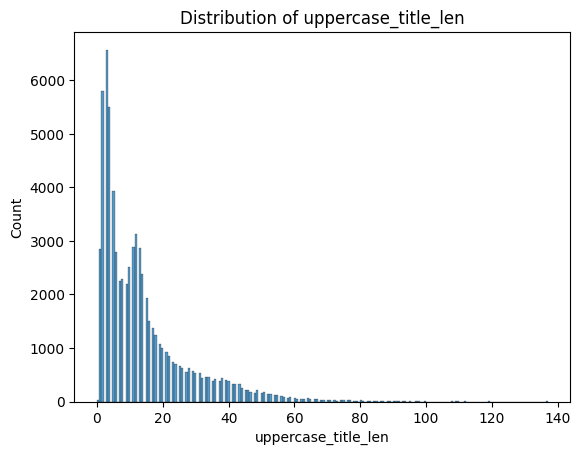

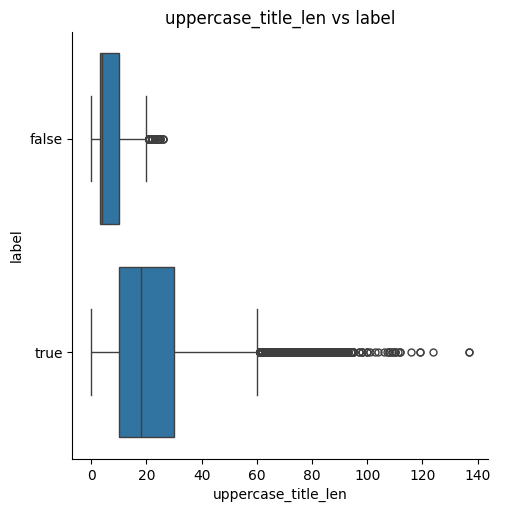

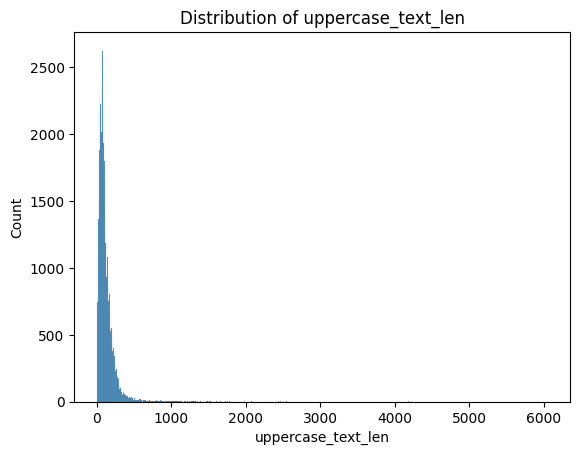

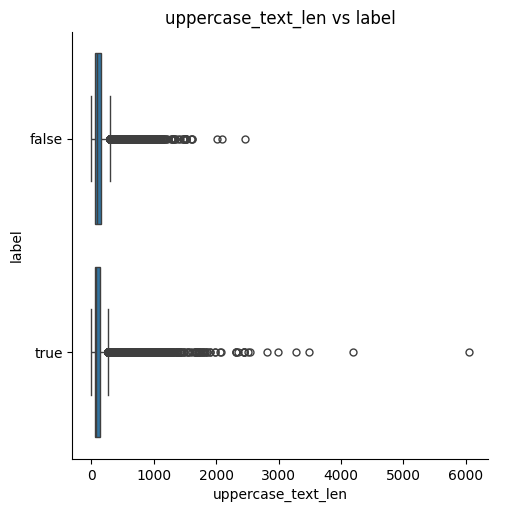

In [30]:
# make plots again to see if there's a major difference
make_plots()

/var/folders/0_/_6d3h3hn5zx6yf2n_7v2ntgr0000gn/T/ipykernel_21517/3315662696.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = bow_df.groupby('label').mean().T  # Transpose for words on rows


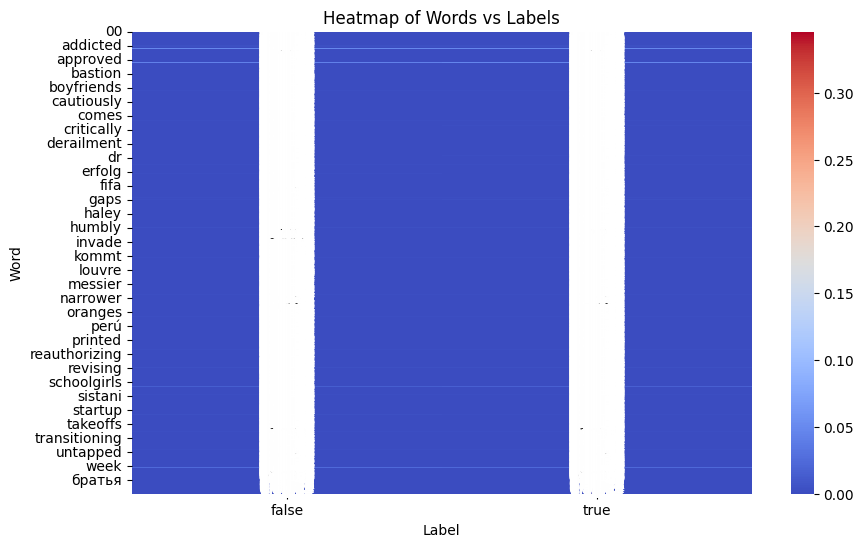

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# convert titles into a Bag of Words matrix
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df['title']).toarray()

# create a DataFrame of BoW with labels
bow_df = pd.DataFrame(bow_matrix, columns=vectorizer.get_feature_names_out())
bow_df['label'] = df['label']

# compute mean occurrence for True/False labels
heatmap_data = bow_df.groupby('label').mean().T  # Transpose for words on rows

# plot it 
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True)
plt.title("Heatmap of Words vs Labels")
plt.xlabel("Label")
plt.ylabel("Word")
plt.show()

### ***Initial Observations to Plots***

Initially looking at these plots, the largest relation we identify is that uppercase_title_len seems to have a higher length for real news articles. We believe that this may be due to the fact that real news articles may have more formal titles, thus leading to an overall increase in the amount of capital letters used in the title. This could be names, towns and cities, or other proper nouns that are capitalized in the title.

Similarly, there's seems to be a similar relationship with title_len being longer for a real news articles. We believe this may be due to the fact that real news articles have more formal titles. A real news articles may require a more descriptive title to accurately describe the content of the article.

In [66]:
# search titles and highlight words that correlate to true or false
def search_titles(search_term, label, print_results=False):
    """ 
    Search titles for a search term and highlight words that correlate to true or false.

    Args:
        search_term (str): The term to search for.
        label (str): The label to search for.
        print_results (bool): Whether to print the results.
    """
    # get the indices of rows where the title contains the search term
    search_results = df[df["title"].str.contains(search_term, case=False)].index

    # get the indices of rows where the label matches the label we're looking for
    label_results = df[df["label"] == label].index

    # get the intersection of the two sets of indices
    common_indices = search_results.intersection(label_results)

    # print the titles of the rows with those indices
    if print_results:
        for index in common_indices:
            print(df.loc[index, "title"])

    # print length of common indices
    print(f'How many common terms we found for {search_term} being {label}: {len(common_indices)}\n')

# search for Trump in labels
search_titles("Trump", "true")
search_titles("Trump", "false")

# search for Biden in labels
search_titles("Biden", "true")
search_titles("Biden", "false")

# search for Fascist in labels
search_titles("Fascist", "true")
search_titles("Fascist", "false")

How many common terms we found for Trump being true: 10820

How many common terms we found for Trump being false: 8480

How many common terms we found for Biden being true: 105

How many common terms we found for Biden being false: 86

How many common terms we found for Fascist being true: 33

How many common terms we found for Fascist being false: 13



### ***Function to search titles for certain terms***

We created the search_terms function which searches our text files to see if a certain word is present. This function can be used to see if there's certain terms that are more likely to be present in true or fake news articles. 

Zach and Preston just had the idea to create this function, as he thought it's an interesting concept. Usability of it may be limited, but it's cool to see if there's any terms that are more likely to be present in fake news articles.

In [62]:
# list of common terms to ignore searching for
ignore = [
    'of', 'the', 'The', 'a', 'is', 'in', 'to', 'and', 'on', 'for', 'by', 
    'with', 'as', 'from', 'at', 'this', 'an', 'or', 'it', 'that', 'was',
    'be', 'not', 'are', 'while', 'for', 'after', 'over', 'up', 'down', 's',
    'he', 'have', 'his', 'her', 'they', 'their', 'we', 'our', 'us', 'you',
    'has', 'had', 'will', 'would', 'should', 'could', 'can', 'do', 'did',
    '”', '—', '[Video]', '(Video)', '[VIDEO]', '(VIDEO)', '–', '-'
]


def count_terms(label, column):
    """ 
    Counts common terms in the corresponding label.

    Args:
        label (str): true or false label to search
    """
    # get the indices of rows where the label matches the label we're looking for
    label_results = df[df["label"] == label].index

    # get the text of the rows with those indices
    text = df.loc[label_results, column]

    # join the text into one big string
    text = " ".join(text)

    # split the text into words
    words = text.split()

    # count the frequency of each word
    word_counts = pd.Series(words).value_counts()

    # remove common terms from the word counts
    word_counts = word_counts.drop(ignore, errors='ignore')

    # print the 20 most common words
    print(f'Top 20 most common words in {label} {column}: \n{word_counts.head(20)}\n\n')

# count common terms in true/false text
count_terms("true", "text")
count_terms("false", "text")

# count common terms in true/false title
count_terms("true", "title")
count_terms("false", "title")

Top 20 most common words in true text: 
Trump      82834
I          71195
who        63594
about      51272
but        42843
been       42302
t          39500
all        38996
were       37995
people     36620
what       35387
more       35052
one        34203
which      34071
out        33634
Clinton    33587
said       31265
she        31210
just       30062
when       29765
Name: count, dtype: int64


Top 20 most common words in false text: 
said      122143
who        73667
Trump      69964
Mr.        65366
about      49962
were       48050
been       47377
but        46136
said.      45015
which      44548
I          44433
more       43798
U.S.       41264
its        41247
she        35943
also       35612
one        33006
people     31763
than       31193
But        29991
Name: count, dtype: int64


Top 20 most common words in true title: 
To         8779
Trump      7194
For        4561
In         4255
Of         4114
A          3621
On         3262
Is         2757
And        258

### ***Function to count common words***

Similarly to the last section of checking specified words, Zach also was curious about seeing what the most common words were across all articles. This could be useful for future analysis, as we could see if there's any words that are more likely to be present in fake news articles. We aren't able to find any explicitly noticeable trends, but again it's an interesting idea to see if there's any words that are more likely to be present in fake news articles.

This may be useful again in future analysis, as we can see exact words which tend to be more common.

In [72]:
from spellchecker import SpellChecker
def num_typo(label) -> bool:
    """
    counts the number of typos in true or false titles.
    
    Args:
        label (str): true or false label to search
    
    Returns:
        bool: True if the title contains a typo, False otherwise.
    """
    spell = SpellChecker()

    # get the indices of rows where the label matches the label we're looking for
    label_results = df[df["label"] == label].index

    # get the text of the rows with those indices
    text = df.loc[label_results, "title"]

    # split words by a space
    words = " ".join(text).split()

    # find misspelled words
    misspelled = spell.unknown(words)

    # print amount of misspelled words
    print(f'Number of misspelled words in {label}: {len(misspelled)}\n')

# check if the title contains a typo
num_typo("true")
num_typo("false")

Number of misspelled words in true: 28571

Number of misspelled words in false: 22166



### ***Function to Count Typos***

Zach had the idea to create a function which counted typos or misspellings in the titles for the articles, assuming that false titles may contain more typos. Oddly enough, we found that real news articles had more typos in their titles. This could be due to the fact that real news articles may have more formal titles, which may lead to more typos. Names, places, or proper nouns may be more present and leading to this oddity. 